In [3]:
import pandas as pd      
import matplotlib.pyplot as plt
from datetime import timedelta

def get_number_of_seats(directory):
    """ Gets the number of seats from the release directory"""
    master = pd.read_csv( os.path.join(directory, "MASTER.txt"), low_memory=False)
    aircraft = pd.read_csv( os.path.join(directory, "ACFTREF.txt"), low_memory=False)

    master = master[['N-NUMBER', 'MFR MDL CODE']]
    aircraft = aircraft[['CODE', 'MFR', 'MODEL', 'NO-SEATS']]

    df = pd.merge(master, aircraft, left_on="MFR MDL CODE", right_on="CODE")
    df.columns = [ x.lower() for x in df.columns ]
    return df

def _drop_n(x):
    if str(x).startswith('N'):
        return x[1:]
    return str(x)

# Note: 
This notebook will not run without the data files necessary: "Gate Utilization (10.2017-10.2018) 2.csv" and "release/..." Please email Lindy Williams at Lindy.Williams@nrel.gov or Monte Lunacek at Monte.Lunacek@nrel.gov for questions regarding access to this data.

# Data Processing

In [4]:
filename = "data/Gate Utilization (10.2017-10.2018) 2.csv"
gu = pd.read_csv(filename)
gu.columns = [ x.lower() for x in gu.columns ]

In [5]:
# we are assuming that every plane that arrives, departs immediately

arrivals = gu[['terminal', 'gate', 'tail_num', 'ac_type', 'arr_airline_code', 
               'arr_flight_num', 'arr_airline_name', 'arr_gatetime', 'gatetime']].copy()
departures = gu[['terminal', 'gate', 'tail_num', 'ac_type', 'dept_airline_code', 
                 'dept_flight_num', 'dept_airline_name',  'dept_gatetime', 'gatetime']].copy()

arrivals['AD'] = 'A'
departures['AD'] = 'D'

arrivals.columns = ['terminal', 'gate', 'tail_num', 'ac_type', 'airline_code', 
                    'flight_num', 'airline_name', 'datetime', 'backupdatetime', 'AD']
departures.columns = ['terminal', 'gate', 'tail_num', 'ac_type', 'airline_code', 
                      'flight_num', 'airline_name', 'datetime', 'backupdatetime', 'AD']

df = pd.concat([arrivals, departures])
df['count'] = 1

df.loc[df['datetime'].isnull(), 'datetime'] = df.loc[df['datetime'].isnull(), 'backupdatetime'] 

df['datetime'] = pd.to_datetime(df['datetime'])

df['tail_num'] = df['tail_num'].map(_drop_n)

/anaconda2/envs/athena/lib/python3.6/site-packages/dateutil/parser/_parser.py:1204: UnknownTimezoneWarning: tzname CDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/anaconda2/envs/athena/lib/python3.6/site-packages/dateutil/parser/_parser.py:1204: UnknownTimezoneWarning: tzname CST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [15]:
# reading in data on seats per plane and merging the gate utilization and seat data

seats = get_number_of_seats(os.path.join("data/ATHENA/data/release"))
with_seats = pd.merge(df, seats, left_on='tail_num', right_on='n-number')

We are droping a few... approximately 6%

Doing some dataframe manipulation for plotting purposes.

In [22]:
piv = (with_seats.pivot_table(index='datetime', columns=['terminal'], values=['count', 'no-seats'])
           .resample('30min')
           .sum())

In [23]:
piv1 = piv.reset_index().melt(id_vars=['datetime'])
piv1.columns = ['datetime', 'variable', 'terminal', 'value']
piv1['time'] = piv1['datetime'].map(lambda x: x.time())
piv1['day'] = piv1['datetime'].map(lambda x: x.day)
piv1['month'] = piv1['datetime'].map(lambda x: x.month)

In [24]:
piv2 = piv1.pivot_table(index='time', 
                columns=['variable', 'terminal', 'day', 'month'], 
                values='value', 
                aggfunc='sum')

# Number of Flights by Terminal

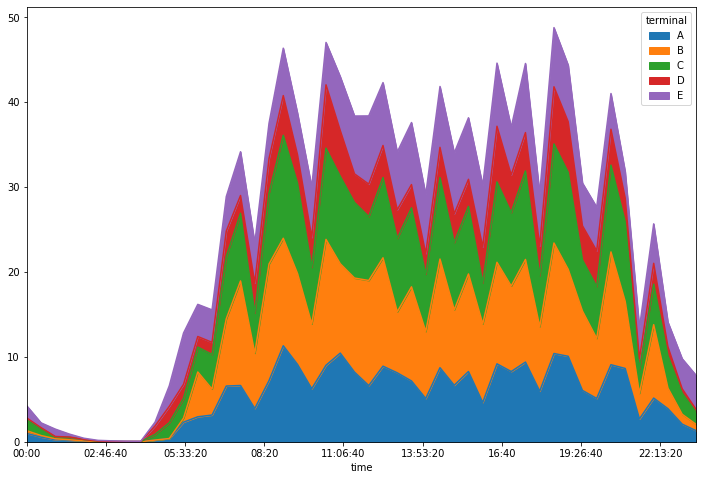

In [27]:
(piv2['count'].sum(axis=1, level=(0, 1,2))
            .mean(axis=1, level=(0))[['A', 'B', 'C', 'D', 'E']]
            .plot(figsize=(12,8), stacked=True, kind='area'))

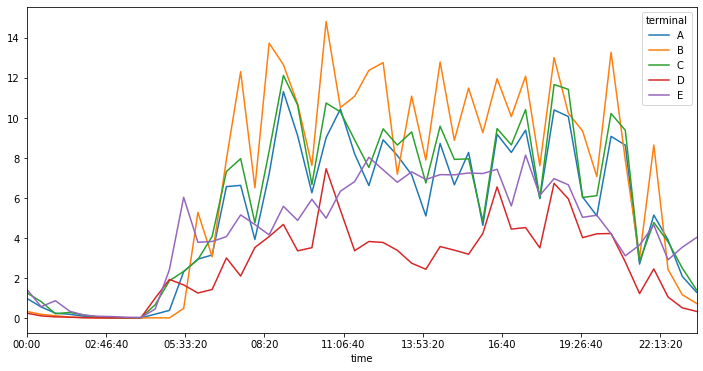

In [28]:
(piv2['count'].sum(axis=1, level=(0, 1,2))
            .mean(axis=1, level=(0))[['A', 'B', 'C', 'D', 'E']]
            .plot(figsize=(12,6)))

From these two plots, we can see that Terminal B has more flights than the others on average, but it does vary based on time of day. Terminal D appears to have the smallest number of flights coming in on average.

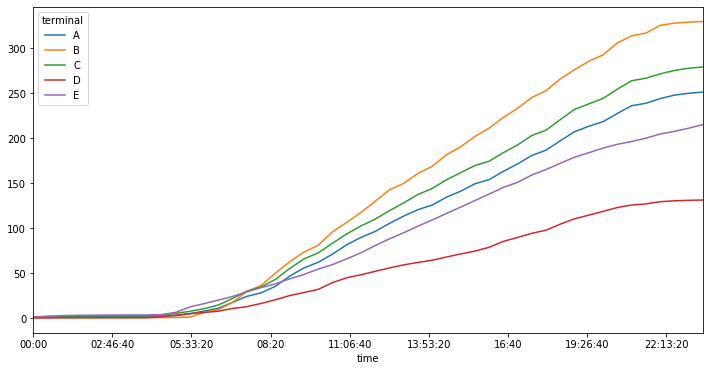

In [45]:
piv3 = (piv2['count'].sum(axis=1, level=(0, 1,2))
                .mean(axis=1, level=(0))[['A', 'B', 'C', 'D', 'E']])
piv3.cumsum().plot(figsize=(12,6))

A different view of the number of flights, on average, throughout the day. We can see that B has the largest total number and D has the smallest total number of flights on average.

# Number of Seats by Terminal 

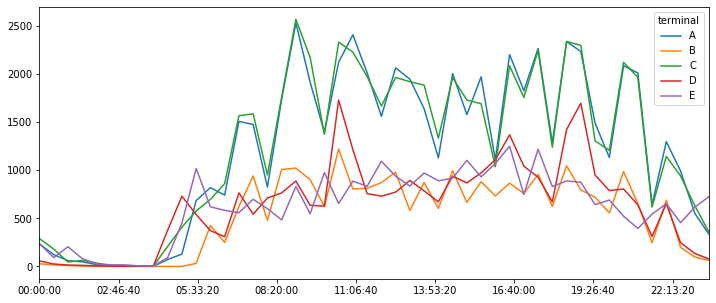

In [53]:
term_by_seats.index = pd.timedelta_range(start='0', freq="30min", periods=48)
term_by_seats.plot(figsize=(12,5))

Instead of looking at the total number of flights, we are now looking at the average number of seats throughout the day. This will take into account larger planes and we can see that Terminal A and C have the largest total number of seats.

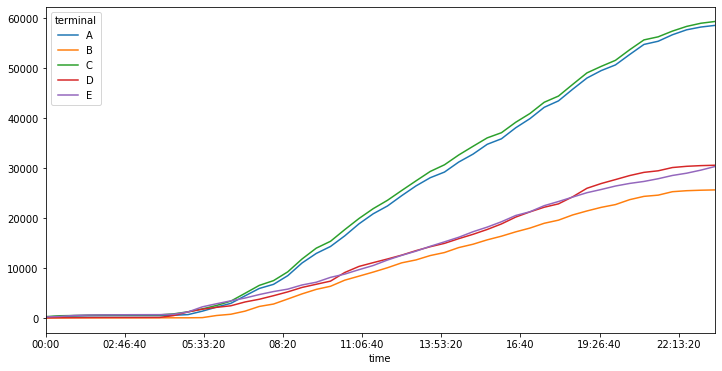

In [47]:
term_by_seats = (piv2['no-seats'].sum(axis=1, level=(0,1,2))
                .mean(axis=1, level=(0))[['A', 'B', 'C', 'D', 'E']])
term_by_seats.cumsum().plot(figsize=(12,6))

Looking at the average total number of seats throughout the day, we can see this plot confirms that A and C have a larger total number of seats.

What about variability?

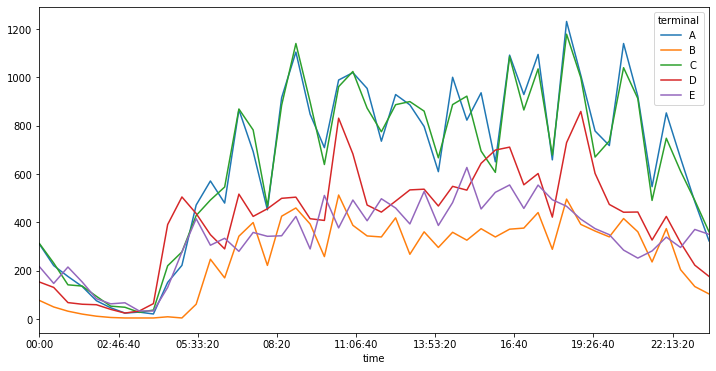

In [54]:
(piv2['no-seats'].sum(axis=1, level=(0, 1,2))
                .std(axis=1, level=(0))[['A', 'B', 'C', 'D', 'E']]).plot(figsize=(12,6))

Now we are visualizing the standard deviation per terminal throughout the day. Terminals A and C also have the highest standard deviation of seats, on average.

Since we are really only concerned with the hours between 6am and 10pm, we will further focus on this subset of data.

In [48]:
# Subsetting for hours between 6am and 10pm
op_hours = piv2['no-seats']
op_hours.index = pd.timedelta_range(start='0', freq="30min", periods=48)
op_hours = op_hours["06:00:00":"22:00:00"]
op_hours = op_hours[['A', 'B', 'C', 'D', 'E']]

Text(0.5, 0, 'Seats')

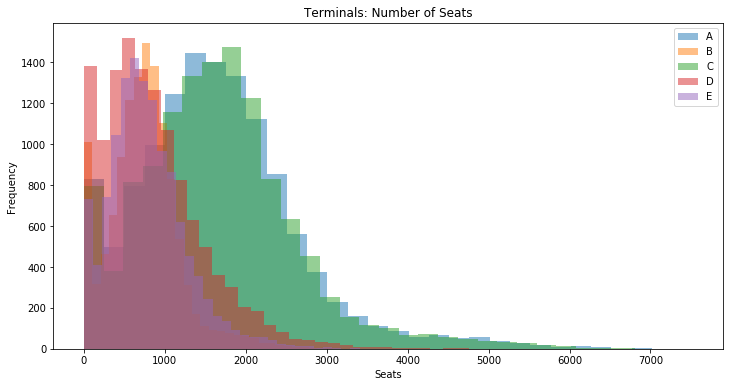

In [49]:
plt = pd.melt(op_hours).groupby('terminal')['value'].plot(x=['Seats'], kind='hist', alpha=0.5, figsize=(12,6),bins=30, title="Terminals: Number of Seats", legend=True)
plt[0].set_xlabel('Seats')

This plot shows the differences in distributions for number of seats between all the terminals. We can see that Terminals D, B, and E have similar distributions, as do Terminals A and C. 

## Terminal by Percentage of Seats

Text(0, 0.5, 'Proportion')

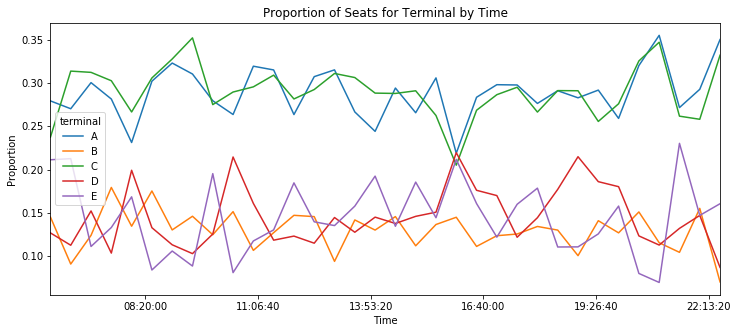

In [38]:
total = term_by_seats.sum(axis=1)
percent = term_by_seats.divide(total, axis=0)
percent.index = pd.timedelta_range(start='0', freq="30min", periods=48)
plt = percent["06:00:00":"22:00:00"].plot(figsize=(12,5), title = "Proportion of Seats for Terminal by Time")
plt.set_xlabel("Time")
plt.set_ylabel("Proportion")

To give more context, this plot shows the proportion of seats for a given time for each Terminal. We can see that generally Terminals A and C have approximately 3 times as many passengers as Terminals B, D, and E.